In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

import os

C:\Program Files\Anaconda3\envs\carmi_thesis_3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import importlib
import plot, loaders
plot = importlib.reload(plot)
loaders = importlib.reload(loaders)

In [3]:
PGS_DIR = os.path.join("data", "pgs")
SAVE_FIG_DIR = "figure2"

# Gain as function of # siblings

Theoretical model:
$$
E[\hat{y}] = \sigma_y h_p \Phi_{max}(n) \sqrt{1 - \rho}
$$

## Longevity Height Model

In [4]:
longevity_data = loaders.load_longevity_data(pgs_col=os.path.join(PGS_DIR, "longevity_height"), convert_to_cm=True)
longevity_data.head()

const  Gender  Age       PGS  Height
FID IID                                      
2   427    1.0       0   61  0.000028  157.48
    448    1.0       1   62  0.000028  177.80
11  615    1.0       0   64  0.000042  157.48
    616    1.0       1   65  0.000086  172.72
24  887    1.0       1   65  0.000106  187.96

In [5]:
height_model_covar = sm.OLS(endog=longevity_data["Height"], exog=longevity_data[["const", "Gender", "Age"]]).fit()
print(height_model_covar.rsquared)
height_model_pgs_res = sm.OLS(endog=height_model_covar.resid, exog=longevity_data[["const", "PGS"]]).fit()
print(height_model_pgs_res.summary())

0.6083835435619124
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     65.49
Date:                Mon, 05 Aug 2019   Prob (F-statistic):           5.18e-14
Time:                        21:22:41   Log-Likelihood:                -635.79
No. Observations:                 206   AIC:                             1276.
Df Residuals:                     204   BIC:                             1282.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6249      0.788 

## ASPIS IQ Model

In [6]:
aspis_data = loaders.load_aspis_data(pgs_col=os.path.join(PGS_DIR, "aspis_gcf"))
aspis_data.head()

const       PGS         IQ
FID IID                            
5   5      1.0  0.000005  95.673167
10  10     1.0 -0.000014  98.480256
11  11     1.0 -0.000012  91.335666
22  22     1.0 -0.000005  87.262629
41  41     1.0 -0.000008  97.917961

In [7]:
iq_model_pgs = sm.OLS(endog=aspis_data["IQ"], exog=aspis_data[["const", "PGS"]]).fit()
print(iq_model_pgs.summary())

                            OLS Regression Results                            
Dep. Variable:                     IQ   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     41.66
Date:                Mon, 05 Aug 2019   Prob (F-statistic):           1.76e-10
Time:                        21:22:46   Log-Likelihood:                -3770.8
No. Observations:                 919   AIC:                             7546.
Df Residuals:                     917   BIC:                             7555.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.3033      0.824    126.628      0.0

## Prediction

In [14]:
longevity_so_50_height_pgs = pd.concat({"random": loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_random_50_height")),
                                        "actual": loaders.load_pgs(os.path.join(PGS_DIR, "longevity_so_actual_50_height"))},
                                       axis="index", names=["matching"])
longevity_so_50_height_pred = height_model_pgs_res.predict(sm.add_constant(longevity_so_50_height_pgs))
longevity_so_50_height_pred.sample(n=6)

matching  FID        IID 
actual    3722_3723  SO23    5.892112
random    1131_6928  SO08    5.373677
actual    3679_3860  SO15    3.308397
random    3127_6039  SO41    6.027943
actual    6504_6505  SO42    0.041103
          5995_5996  SO30   -2.874040
dtype: float64

In [15]:
aspis_so_50_gcf_pgs = loaders.load_pgs(os.path.join(PGS_DIR, "aspis_so_random_50_gcf"))
aspis_so_50_gcf_pred = iq_model_pgs.predict(sm.add_constant(aspis_so_50_gcf_pgs))
aspis_so_50_gcf_pred.head()

FID        IID 
1022_4296  SO00    97.697219
           SO01    97.846535
           SO02    99.167459
           SO03    97.801777
           SO04    96.983601
dtype: float64

## Compare to theoretical model

#### Sample increasing size families

In [16]:
def sample_subset(df, groupby_colname="FID"):
    res = {}
    max_fam_size = df.groupby(groupby_colname).size().iloc[0]
    for n in range(max_fam_size, 0, -1):
        df = df.groupby(groupby_colname).apply(lambda x: x.sample(n=n))
        res[n] = df.copy()
    return res

In [17]:
longevity_so_height_pred = {"random": sample_subset(longevity_so_50_height_pred.xs("random")),
                            "actual": sample_subset(longevity_so_50_height_pred.xs("actual"))}
aspis_so_iq_pred = sample_subset(aspis_so_50_gcf_pred)

#### Calculate gain

In [18]:
def calculate_gain(dfs, groupby_colname="FID"):
    res = {}
    for n, df in dfs.items():
        gain = df.groupby(groupby_colname).agg(["max", "mean"])
        gain = gain["max"] - gain["mean"]
        gain = gain.agg(["mean", "sem", "std"])
        gain["ci95"] = stats.norm.ppf(0.95) * gain["sem"]
        res[n] = gain
    res = pd.DataFrame(res).T
    res.index.names = ["n_sib"]
    return res

In [19]:
so_gain = pd.concat({"Longevity random": calculate_gain(longevity_so_height_pred["random"]),
                     "Longevity actual": calculate_gain(longevity_so_height_pred["actual"]),
                     "ASPIS random": calculate_gain(aspis_so_iq_pred)})
so_gain.sample(6)

mean       sem       std      ci95
                 n_sib                                        
Longevity actual 33     4.143513  0.103466  1.044953  0.170186
                 47     4.452970  0.092282  0.931999  0.151790
                 2      1.118575  0.090534  0.914353  0.148916
                 24     3.837166  0.099672  1.006640  0.163946
ASPIS random     29     4.363034  0.095668  0.956678  0.157360
Longevity random 6      0.460194  0.020621  0.206208  0.033918

Sample and calculate for efficiency:

#### Extract PG scores of current parents

In [15]:
def extract_parents_pgs(predictions, source_pgs, groupby_colnames):
    # Simulations' FID contain parents IDs:
    parents = predictions.index.to_frame().reset_index(drop=True)
    # Filter the manny IIDs for each FID:
    parents = parents.groupby(groupby_colnames).first().index.to_frame().reset_index(drop=True)
    # Split the FID into its parents IID components:
    parents = parents.join(parents["FID"].str.split("_", expand=True).astype(int))
    # Convert the new parents IID component into their corresponding PG score:
    parents = parents.join(parents[[0, 1]].applymap(lambda x: source_pgs.xs(x, level="IID").iloc[0]), rsuffix="_pgs")
    return parents

In [54]:
parents_pgs = pd.concat({"Longevity random": extract_parents_pgs(longevity_so_50_height_pred.xs("random"), 
                                                                 longevity_data["PGS"], ["FID"]),
                         "Longevity actual": extract_parents_pgs(longevity_so_50_height_pred.xs("actual"), 
                                                                 longevity_data["PGS"], ["FID"]),
                         "ASPIS random":  extract_parents_pgs(aspis_so_50_gcf_pred, aspis_data["PGS"], ["FID"])},
                        names=["set"])
parents_correlations = parents_pgs.groupby(["set"]).corr()
parents_correlations = parents_correlations.loc[pd.IndexSlice[:, "0_pgs"], "1_pgs"].rename("data")
parents_correlations.index = parents_correlations.index.droplevel(1)
parents_correlations = parents_correlations.to_frame().assign(no=0)
parents_correlations

data  no
set                           
ASPIS random      0.076156   0
Longevity actual  0.129399   0
Longevity random -0.022785   0

In [64]:
pgs_models = {"Height": height_model_pgs_res, "IQ": iq_model_pgs}

In [66]:
import pickle
with open(os.path.join(SAVE_FIG_DIR, "plot_data.pkl"), "wb") as fh:
    pickle.dump((so_gain, pgs_models, parents_correlations), fh)
# with open(os.path.join(SAVE_FIG_DIR, "plot_data.pkl"), "rb") as fh:
#     z = pickle.load(fh)

### Plot

In [30]:
PLOT_THICKENS = True
if PLOT_THICKENS:
    # sns.plotting_context("talk")
    CUSTOM_SNS_RC = {'xtick.labelsize': 13.5, 'ytick.labelsize': 13.5, 'legend.fontsize': 13.0, 
                                                 'axes.labelsize': 14, 'axes.titlesize': 15}
    # sns.set_context("paper", font_scale=1.4, rc=CUSTOM_SNS_RC)
    sns.set_context("talk", font_scale=1, rc=CUSTOM_SNS_RC)
else:
    sns.set_context("paper")
    plt.rcParams['xtick.major.pad']= '0'
    plt.rcParams['ytick.major.pad']= '1'
    plt.rcParams['legend.fontsize'] = '7.5'

In [36]:
APPROX_MAX = False
DILLUTE_TICKS = False
UNIT_TICKS = False
SD_SCALED = False

Expectation of the maximum of a Gaussian random variable:  
As stated [here](https://math.stackexchange.com/questions/89030/expectation-of-the-maximum-of-gaussian-random-variables).  
$$
\Phi_{max}(n) = \frac{1}{\sqrt{2}}
                \left( 
                      \gamma \Phi^{-1}\left( 1 - \frac{1}{en} \right) - 
                      \left(\gamma - 1 \right) \Phi^{-1}\left(1 - \frac{1}{n} \right)
                \right)
$$
Where $\gamma=0.5772$ is the Euler-Mascheroni constant,  
And $\Phi^{-1}$ is the inverse CDF of normal distribution

In [138]:
def gauss_max_exp(n, approx=False, approx_scale=0.77):
    if approx:
        phi_max = np.sqrt(np.log(n)) * approx_scale
    else:
        gamma = 0.5772
        phi_max = stats.norm().ppf(1 - 1/n)
        phi_max += gamma / (n * stats.norm().pdf(phi_max))
#         phi_max = (gamma*stats.norm().ppf(1-1/(np.e*n)) - (gamma-1)*stats.norm().ppf(1-1/n)) / np.sqrt(2)
    return phi_max
#     return np.sqrt(2) * ((gamma-1)*stats.norm().ppf(1-1/n) - gamma*stats.norm().ppf(1-1/(np.e*n)))
#     return - np.sqrt(2) * ((gamma-1)*stats.norm().ppf(1-1/n) - gamma*stats.norm().ppf(1-1/(np.e*n)))

In [49]:
def single_plot_1y(empirical_gain, sm_model, parents_correlation, approx_max=False,
                   dillute_ticks=False, color_ticklines=True, tick_units=False,
                   y_label=None, x_label=None, legend_loc=None, ax=None):
    ax = ax or plt.gca()  
    n_sibs_domain = np.linspace(1.5, empirical_gain["n_sib"].max(), 100)
    empirical_gain = empirical_gain.sort_values(by="n_sib")
    
    # Plot empirical
    ax.plot(empirical_gain["n_sib"], empirical_gain["mean"], 
            marker=".", label="Empirical")
    ax.fill_between(x=empirical_gain["n_sib"], 
                    y1=(empirical_gain["mean"] - empirical_gain["ci95"]), 
                    y2=(empirical_gain["mean"] + empirical_gain["ci95"]), 
                    alpha=0.2, label="95% CI")
    
    # Plot Theoretical:
    sigma_y = sm_model.model.endog.std()
    h_p = np.sqrt(sm_model.rsquared)
    rho = np.sqrt(1 - parents_correlation)
    expected_family_max = gauss_max_exp(n_sibs_domain, approx_max)
    theoretical_curve = sigma_y * h_p * expected_family_max * rho / np.sqrt(2)
    if approx_max:
        theoretical_curve *= np.sqrt(2)
    ax.plot(n_sibs_domain, theoretical_curve, label="Theoretical", alpha=0.9)
    
    ax.yaxis.set_tick_params(pad=1)
    ax.yaxis.labelpad = 0.2
    ax.xaxis.set_tick_params(pad=1)
    ax.xaxis.labelpad = 1

    # Edit:
    ax.legend(loc=legend_loc)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    return ax

In [69]:
def plot_figure(longevity_gain, height_model, aspis_gain, iq_model, parents_corr,
                approx_max, dillute_ticks, tick_units, 
                sd_scaled, sharey, plot_thickens=True, color_ticklines=True,
                legend_loc="lower right", figsize=(18, 5)):
    legend_loc = "lower right"
    xlabel = "# Embryos [n]"
#     ax_title_size = 8
#     plt.rcParams['axes.titlepad'] = 3
    fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False)

    single_plot_1y(longevity_gain.xs("random").reset_index(), height_model,
                   parents_corr.loc["Longevity random"], approx_max=approx_max,
                   dillute_ticks=dillute_ticks, color_ticklines=color_ticklines, 
                   tick_units=tick_units, legend_loc=legend_loc,
                   y_label="Gain [cm]", x_label=xlabel, ax=axes[0])
    axes[0].set_title("Longevity Random Matching")

    single_plot_1y(longevity_gain.xs("actual").reset_index(), height_model, 
                   parents_corr.loc["Longevity actual"], approx_max=approx_max,
                   dillute_ticks=dillute_ticks, color_ticklines=color_ticklines, 
                   tick_units=tick_units, legend_loc=legend_loc,
                   y_label="Gain [cm]", x_label=xlabel, ax=axes[1])
    axes[1].set_title("Longevity Actual Matching")

    single_plot_1y(aspis_gain.reset_index(), iq_model, 
                   parents_corr.loc["ASPIS random"], approx_max=approx_max,
                   dillute_ticks=dillute_ticks, color_ticklines=color_ticklines, 
                   tick_units=tick_units, legend_loc=legend_loc,
                   y_label="Gain [IQ]", x_label=xlabel, ax=axes[2])
    axes[2].set_title("ASPIS Random Matching")
    # ax_iq.yaxis.set_label_coords(-0.19, 0.5)
    # ax_iq.set_yticks(ax[2].get_yticks() * iq_model_pgs.model.endog.std())

    suptitle = "Gain as Function of Number of Embryos"
    if plot_thickens:
        fig.suptitle(suptitle, fontsize=18, y=1.03)
        fig.subplots_adjust(wspace=0.34)
    else:
        fig.suptitle(suptitle, fontsize=14, y=1.00)
        fig.subplots_adjust(wspace=0.3)

    if sd_scaled:
        axes[0].get_shared_y_axes().join(axes[0], axes[1], axes[2])
        axes[2].autoscale()
    if sharey:
        max_ylim = max([ax.get_ylim()[1] for ax in axes])
        min_ylim = min([ax.get_ylim()[0] for ax in axes])
        [ax.set_ylim(min_ylim, max_ylim) for ax in axes]
    
#     axes[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=3)

    # ax_height_1.get_shared_y_axes().join(ax_height_1, ax_height_2, ax_iq)
    # ax_iq.autoscale()
    # ax[0].set_ylim(-0.05, 0.85);
    return fig, axes

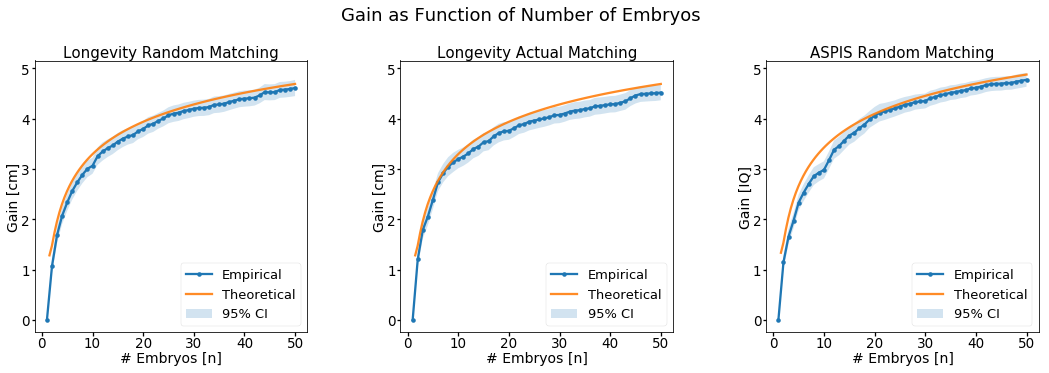

In [132]:
APPROX_MAX = False
DILLUTE_TICKS = False
UNIT_TICKS = False
SD_SCALED = False
SHAREY = True
pc="no"
fig, axes_left = plot_figure(longevity_so_height_gain, height_model_pgs_res,
                             aspis_so_iq_gain, iq_model_pgs, parents_correlations[pc],
                             APPROX_MAX, DILLUTE_TICKS, UNIT_TICKS, SD_SCALED, SHAREY)

In [133]:
file_name = ("gain-by-nsibs" + 
            ("_thick" if PLOT_THICKENS else "") + 
            ("_approx" if APPROX_MAX else "") + 
            ("_pc-{}".format(pc)) + 
            ("_sharey" if SHAREY else "") +
            ("_dillute" if DILLUTE_TICKS else "") + 
            ("_SDticks" if UNIT_TICKS else "") + 
            ("_SDscaled" if SD_SCALED else ""))
print(file_name)
plot.save_fig(fig, file_name, SAVE_FIG_DIR)

gain-by-nsibs_thick_pc-no_sharey


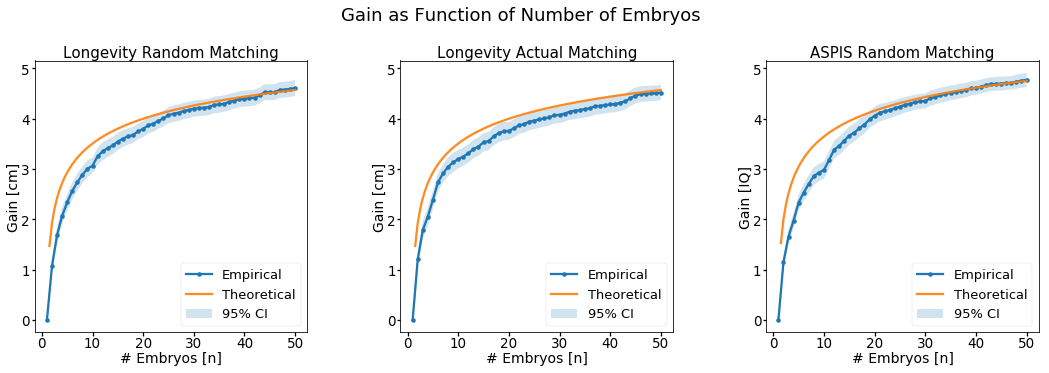

In [139]:
APPROX_MAX = True
DILLUTE_TICKS = False
UNIT_TICKS = False
SD_SCALED = False
SHAREY = True
pc = "no"
fig, axes_left = plot_figure(longevity_so_height_gain, height_model_pgs_res,
                             aspis_so_iq_gain, iq_model_pgs, parents_correlations[pc],
                             APPROX_MAX, DILLUTE_TICKS, UNIT_TICKS, SD_SCALED, SHAREY)

In [113]:
file_name = ("gain-by-nsibs" + 
            ("_thick" if PLOT_THICKENS else "") + 
            ("_approx" if APPROX_MAX else "") + 
            ("_pc-{}".format(pc)) + 
            ("_sharey" if SHAREY else "") + 
            ("_dillute" if DILLUTE_TICKS else "") + 
            ("_SDticks" if UNIT_TICKS else "") + 
            ("_SDscaled" if SD_SCALED else ""))
print(file_name)
plot.save_fig(fig, file_name, SAVE_FIG_DIR)

gain-by-nsibs_thick_approx_pc-no_sharey


#### With SD units specify on each tick

In [38]:
def single_plot_2y(empirical_gain, sm_model, parents_correlation=0, approx_max=False,
                   dillute_ticks=False, color_ticklines=True, tick_units=False,
                   y_label=None, x_label=None, legend_loc=None, ax=None):
    ax = ax or plt.gca()  
    n_sibs_domain = np.linspace(1.5, empirical_gain["n_sib"].max(), 100)
    empirical_gain = empirical_gain.sort_values(by="n_sib")
    
    y_sd = sm_model.model.endog.std()
    # First plot by SD, to make it the main axis, so later it will the determine the scale
    
    # Plot empirical
    ax.plot(empirical_gain["n_sib"], empirical_gain["mean"] / y_sd, 
            marker=".", label="Empirical")
    ax.fill_between(x=empirical_gain["n_sib"], 
                    y1=(empirical_gain["mean"] - empirical_gain["ci95"]) / y_sd, 
                    y2=(empirical_gain["mean"] + empirical_gain["ci95"]) / y_sd, 
                    alpha=0.2, label="95% CI")
    
    # Plot Theoretical:
    sigma_y = sm_model.model.endog.std()
    h_p = np.sqrt(sm_model.rsquared)
    rho = np.sqrt(1 - parents_correlation)
    expected_family_max = gauss_max_exp(n_sibs_domain, approx_max)
    theoretical_curve = sigma_y * h_p * expected_family_max * rho / np.sqrt(2)
    if approx_max:
        theoretical_curve *= np.sqrt(2)
    ax.plot(n_sibs_domain, theoretical_curve / y_sd, label="Theoretical", alpha=0.9)

    # Secondary y-axis in original units:
    ax_sec = ax.twinx()
    ax_sec.plot(empirical_gain["n_sib"], empirical_gain["mean"], 
                marker=".", label="", alpha=0.0)
    ax_sec.plot(n_sibs_domain, theoretical_curve, label="", alpha=0.0)
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax_sec.yaxis.set_major_locator(plt.MaxNLocator(5))
#     if y_sd < 10:   # height
#         ax_sec.yaxis.set_major_locator(plt.MaxNLocator(6, integer=True))
#         ax_sec.yaxis.set_major_locator(plt.MaxNLocator(6, integer=True))
#     else:           # IQ
#         ax_sec.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.yaxis.tick_right()
    ax_sec.yaxis.tick_left()
    for i, tick in enumerate(ax.yaxis.get_ticklabels()):
        tick.set_color("C4")
        tick.set_size(14)
    if color_ticklines:
        [t.set_color('C4') for t in ax.yaxis.get_ticklines()]
    if tick_units:
        if y_sd < 10:   # height
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1fSD'))
        else:           # IQ
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2fSD'))
    else:
        ax.set_ylabel("$\sigma = {:.2f}$".format(y_sd), color="C4", rotation=0)
        ax.yaxis.set_label_coords(1.10, -0.05)
#     if dillute_ticks:
#         for i, tick in enumerate(ax.get_yticklabels()[1:-1]):
#             if i % 2 == 0:
#                 tick.set_visible(False)
#         for i, tick in enumerate(ax.yaxis.get_ticklines()[2:-2]):
#             if tick.get_data()[0][0] == 0:
#                 continue
#             if i % 4 == 1:
#                 tick.set_visible(False)
    
    ax_sec.set_ylabel(y_label)
    ax_sec.yaxis.set_label_position("left")
    
    ax.yaxis.set_tick_params(pad=2)
    ax_sec.yaxis.set_tick_params(pad=3)

    # Edit:
    ax.legend(loc=legend_loc)
    ax.set_xlabel(x_label)
    return ax, ax_sec

In [616]:
UNIT_TICKS = True

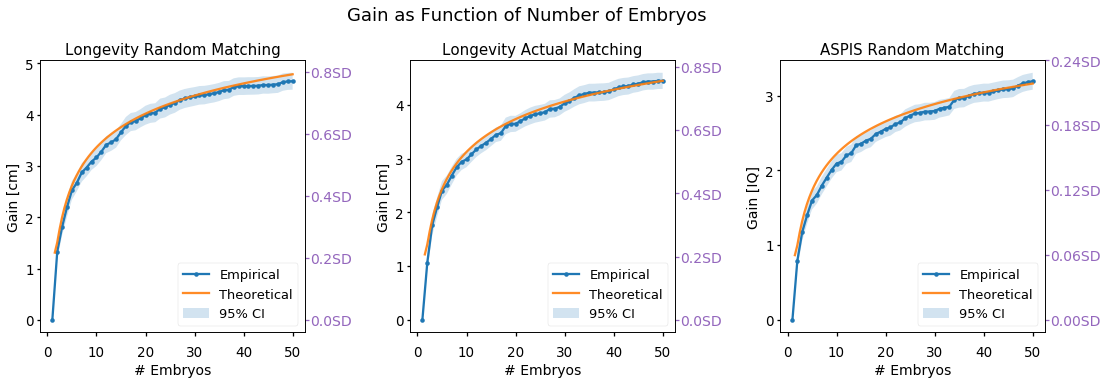

In [617]:
legend_loc = "lower right"
# xlabel = "# embryos in IVF cycle"
xlabel = "# Embryos [n]"
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

_, ax_height_1 = single_plot(longevity_so_height_gain.xs("random").reset_index(), height_model_pgs_res,
                             longevity_correlations.loc["random"], approx_max=APPROX_MAX,
                             dillute_ticks=False, color_ticklines=True, tick_units=UNIT_TICKS,
                             y_label="Gain [cm]", x_label=xlabel, legend_loc=legend_loc, ax=ax[0])
ax[0].set_title("Longevity Random Matching")

_, ax_height_2 = single_plot(longevity_so_height_gain.xs("actual").reset_index(), height_model_pgs_res, 
                             longevity_correlations.loc["actual"], approx_max=APPROX_MAX,
                             dillute_ticks=False, color_ticklines=True, tick_units=UNIT_TICKS,
                             y_label="Gain [cm]", x_label=xlabel, legend_loc=legend_loc, ax=ax[1])
ax[1].set_title("Longevity Actual Matching")

_, ax_iq = single_plot(aspis_so_iq_gain.reset_index(), iq_model_pgs, 
                       aspis_correlations, approx_max=APPROX_MAX,
                       dillute_ticks=False, color_ticklines=True, tick_units=UNIT_TICKS,
                       y_label="Gain [IQ]", x_label=xlabel, legend_loc=legend_loc, ax=ax[2])
ax[2].set_title("ASPIS Random Matching")

# suptitle = "Gain as Function of IVF Cycle Size"
suptitle = "Gain as Function of Number of Embryos"
if PLOT_THICKENS:
    fig.suptitle(suptitle, fontsize=18, y=1.03)
    fig.subplots_adjust(wspace=0.4)
else:
    fig.suptitle(suptitle, fontsize=14, y=1.00)
    fig.subplots_adjust(wspace=0.3)
    
# ax_sd0.get_shared_y_axes().join(ax_sd0, ax_sd1, ax_sd2)
# ax_sd0.autoscale()
if SD_SCALED:
    ax[0].get_shared_y_axes().join(ax[0], ax[1], ax[2])
    ax[2].autoscale()

In [618]:
plot.save_fig(fig, "gain-by-nsibs_horizontal_sdticks_alpha-09_ticklines" + 
                    ("_thick" if PLOT_THICKENS else "") + 
                    ("_approx" if APPROX_MAX else "") + 
                    ("_dillute" if DILLUTE_TICKS else "") + 
                    ("_SDticks" if UNIT_TICKS else "") + 
                    ("_SDscaled" if SD_SCALED else ""),
              SAVE_FIG_DIR)

## With subplots similarly scaled

In [701]:
SD_SCALED = True
APPROX_MAX = False
DILLUTE_TICKS = False
UNIT_TICKS = True

#### With SD units specify on each tick

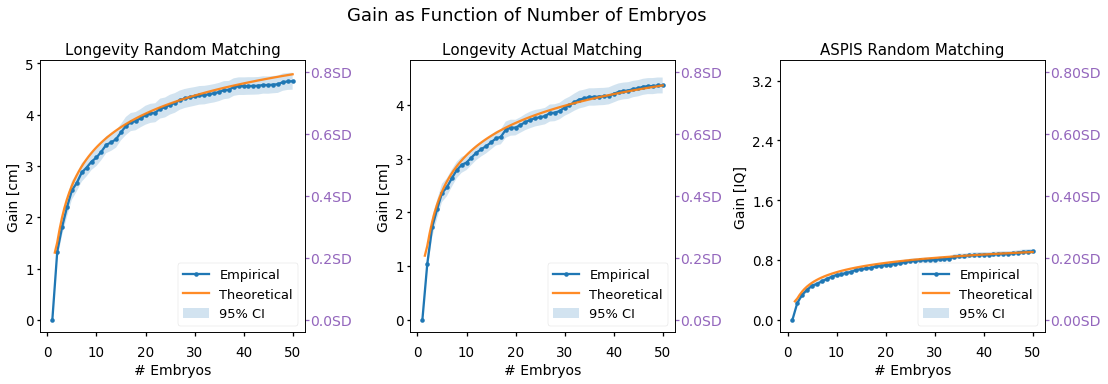

In [702]:
legend_loc = "lower right"
# xlabel = "# embryos in IVF cycle"
xlabel = "# Embryos [n]"
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

_, ax_height_1 = single_plot(longevity_so_height_gain.xs("random").reset_index(), height_model_pgs_res,
                             longevity_correlations.loc["random"], approx_max=APPROX_MAX,
                             dillute_ticks=False, color_ticklines=True, tick_units=UNIT_TICKS,
                             y_label="Gain [cm]", x_label=xlabel, legend_loc=legend_loc, ax=ax[0])
ax[0].set_title("Longevity Random Matching")

_, ax_height_2 = single_plot(longevity_so_height_gain.xs("actual").reset_index(), height_model_pgs_res, 
                             longevity_correlations.loc["actual"], approx_max=APPROX_MAX,
                             dillute_ticks=False, color_ticklines=True, tick_units=UNIT_TICKS,
                             y_label="Gain [cm]", x_label=xlabel, legend_loc=legend_loc, ax=ax[1])
ax[1].set_title("Longevity Actual Matching")

_, ax_iq = single_plot(aspis_so_iq_gain.reset_index(), iq_model_pgs, 
                       aspis_correlations, approx_max=APPROX_MAX,
                       dillute_ticks=False, color_ticklines=True, tick_units=UNIT_TICKS,
                       y_label="Gain [IQ]", x_label=xlabel, legend_loc=legend_loc, ax=ax[2])
ax[2].set_title("ASPIS Random Matching")

# suptitle = "Gain as Function of IVF Cycle Size"
suptitle = "Gain as Function of Number of Embryos"
if PLOT_THICKENS:
    fig.suptitle(suptitle, fontsize=18, y=1.03)
    fig.subplots_adjust(wspace=0.4)
else:
    fig.suptitle(suptitle, fontsize=14, y=1.00)
    fig.subplots_adjust(wspace=0.3)
    
# ax_sd0.get_shared_y_axes().join(ax_sd0, ax_sd1, ax_sd2)
# ax_sd0.autoscale()
if SD_SCALED:
    ax[0].get_shared_y_axes().join(ax[0], ax[1], ax[2])
    ax[2].autoscale()

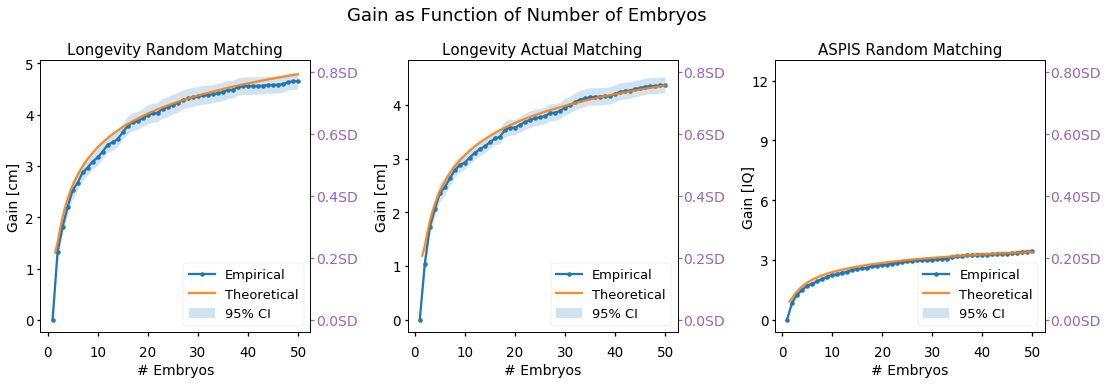

In [713]:
# for tick_iq, tick_sd in zip(ax_iq.get_yticklabels(), ax[2].get_yticklabels()):
#     if tick.get_text() and tick_sd.get_text():
#         new_tick_text = tick_sd.get_text().rstrip('SD')
#         new_tick_text = float(new_tick_text) * 15
#         new_tick_text = "{:.0f}".format(new_tick_text)
#         tick_iq.set_text(new_tick_text)
# fig

# ax_iq.set_yticks(ax[2].get_yticks() * 15)
# ax_iq.yaxis.set_major_locator(ax[2].yaxis.get_major_locator())
# fig

from matplotlib.ticker import FuncFormatter
def fix_iq_units(tick_label, tick_pos):
    return "{:.0f}".format(float(tick_label) / 4 * 15)
ax_iq.yaxis.set_major_formatter(FuncFormatter(fix_iq_units))
ax_iq.yaxis.set_label_coords(-0.07, 0.5)
fig.subplots_adjust(wspace=0.36)
fig

In [714]:
plot.save_fig(fig, "gain-by-nsibs_horizontal_sdticks_alpha-09_ticklines" + 
                    ("_thick" if PLOT_THICKENS else "") + 
                    ("_approx" if APPROX_MAX else "") + 
                    ("_dillute" if DILLUTE_TICKS else "") + 
                    ("_SDticks" if UNIT_TICKS else "") + 
                    ("_SDscaled" if SD_SCALED else ""),
              SAVE_FIG_DIR)
# plot.save_fig(fig, "gain-by-nsibs_horizontal_sdticks_alpha-09_SDlabel_dillute" + ("_thick" if PLOT_THICKENS else ""), 
#               SAVE_FIG_DIR)

#### With SD units specified once

In [715]:
UNIT_TICKS = False

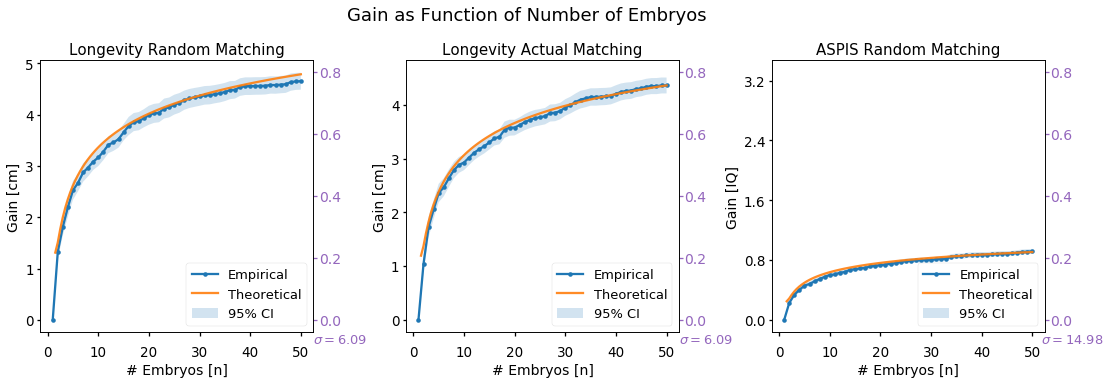

In [718]:
legend_loc = "lower right"
# xlabel = "# embryos in IVF cycle"
xlabel = "# Embryos [n]"
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

_, ax_height_1 = single_plot(longevity_so_height_gain.xs("random").reset_index(), height_model_pgs_res,
                             longevity_correlations.loc["random"], approx_max=APPROX_MAX,
                             dillute_ticks=False, color_ticklines=True, tick_units=False,
                             y_label="Gain [cm]", x_label=xlabel, legend_loc=legend_loc, ax=ax[0])
ax[0].set_title("Longevity Random Matching")

_, ax_height_2 = single_plot(longevity_so_height_gain.xs("actual").reset_index(), height_model_pgs_res, 
                             longevity_correlations.loc["actual"], approx_max=APPROX_MAX,
                             dillute_ticks=False, color_ticklines=True, tick_units=False,
                             y_label="Gain [cm]", x_label=xlabel, legend_loc=legend_loc, ax=ax[1])
ax[1].set_title("Longevity Actual Matching")

_, ax_iq = single_plot(aspis_so_iq_gain.reset_index(), iq_model_pgs, 
                       aspis_correlations, approx_max=APPROX_MAX,
                       dillute_ticks=False, color_ticklines=True, tick_units=False,
                       y_label="Gain [IQ]", x_label=xlabel, legend_loc=legend_loc, ax=ax[2])
ax[2].set_title("ASPIS Random Matching")
# ax_iq.yaxis.set_label_coords(-0.19, 0.5)
# ax_iq.set_yticks(ax[2].get_yticks() * iq_model_pgs.model.endog.std())
    
# suptitle = "Gain as Function of IVF Cycle Size"
suptitle = "Gain as Function of Number of Embryos"
if PLOT_THICKENS:
    fig.suptitle(suptitle, fontsize=18, y=1.03)
    fig.subplots_adjust(wspace=0.34)
else:
    fig.suptitle(suptitle, fontsize=14, y=1.00)
    fig.subplots_adjust(wspace=0.3)
    

if SD_SCALED:
    ax[0].get_shared_y_axes().join(ax[0], ax[1], ax[2])
    ax[2].autoscale()

# ax_height_1.get_shared_y_axes().join(ax_height_1, ax_height_2, ax_iq)
# ax_iq.autoscale()
# ax[0].set_ylim(-0.05, 0.85);

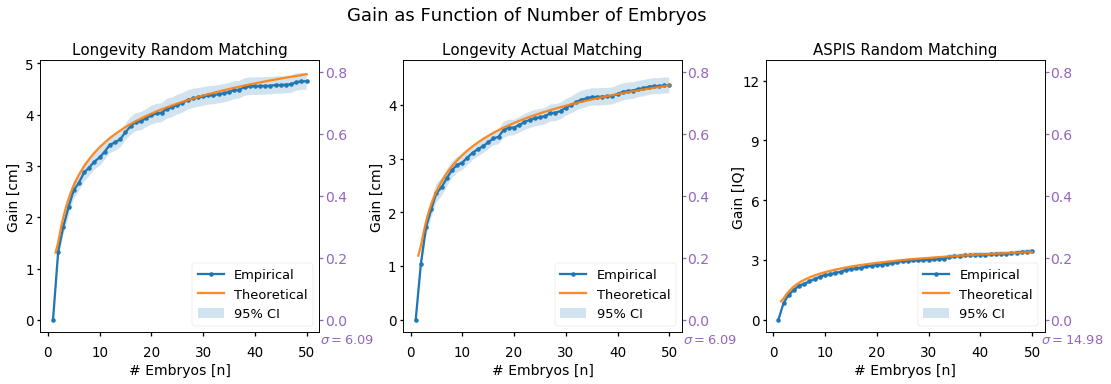

In [721]:
from matplotlib.ticker import FuncFormatter
def fix_iq_units(tick_label, tick_pos):
    return "{:.0f}".format(float(tick_label) / 4 * 15)
ax_iq.yaxis.set_major_formatter(FuncFormatter(fix_iq_units))
ax_iq.yaxis.set_label_coords(-0.07, 0.5)
fig.subplots_adjust(wspace=0.3)
fig

In [722]:
# plot.save_fig(fig, "gain-by-nsibs_horizontal_sdticks_alpha-09_dillute" + ("_thick" if PLOT_THICKENS else ""), SAVE_FIG_DIR)
# plot.save_fig(fig, "gain-by-nsibs_horizontal_sdticks_alpha-09" + ("_thick" if PLOT_THICKENS else ""), SAVE_FIG_DIR)
plot.save_fig(fig, "gain-by-nsibs_horizontal_sdticks_alpha-09_ticklines" + 
                    ("_thick" if PLOT_THICKENS else "") + 
                    ("_approx" if APPROX_MAX else "") + 
                    ("_dillute" if DILLUTE_TICKS else "") + 
                    ("_SDticks" if UNIT_TICKS else "") + 
                    ("_SDscaled" if SD_SCALED else ""),
              SAVE_FIG_DIR)

#### Units only on the right-most

In [723]:
UNIT_TICKS = True

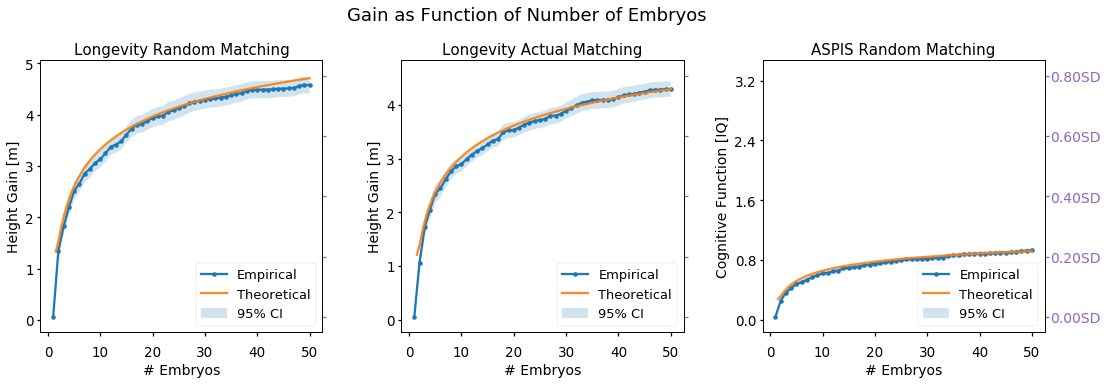

In [724]:
legend_loc = "lower right"
# xlabel = "# embryos in IVF cycle"
xlabel = "# Embryos [n]"
fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

_, ax_height_1 = single_plot(longevity_so_height_gain.xs("random").reset_index(), height_model_pgs_res,
                             longevity_correlations.loc["random"], approx_max=APPROX_MAX,
                             dillute_ticks=DILLUTE_TICKS, color_ticklines=True, tick_units=UNIT_TICKS,
                             y_label="Gain [m]", x_label=xlabel, legend_loc=legend_loc, ax=ax[0])
ax[0].set_title("Longevity Random Matching")

_, ax_height_2 = single_plot(longevity_so_height_gain.xs("actual").reset_index(), height_model_pgs_res, 
                             longevity_correlations.loc["actual"], approx_max=APPROX_MAX,
                             dillute_ticks=DILLUTE_TICKS, color_ticklines=True, tick_units=UNIT_TICKS,
                             y_label="Gain [m]", x_label=xlabel, legend_loc=legend_loc, ax=ax[1])
ax[1].set_title("Longevity Actual Matching")

_, ax_iq = single_plot(aspis_so_iq_gain.reset_index(), iq_model_pgs, 
                       aspis_correlations, approx_max=APPROX_MAX,
                       dillute_ticks=DILLUTE_TICKS, color_ticklines=True, tick_units=UNIT_TICKS,
                       y_label="Gain [IQ]", x_label=xlabel, legend_loc=legend_loc, ax=ax[2])
ax[2].set_title("ASPIS Random Matching")

# suptitle = "Gain as Function of IVF Cycle Size"
suptitle = "Gain as Function of Number of Embryos"
if PLOT_THICKENS:
    fig.suptitle(suptitle, fontsize=18, y=1.03)
    fig.subplots_adjust(wspace=0.28)
else:
    fig.suptitle(suptitle, fontsize=14, y=1.00)
    fig.subplots_adjust(wspace=0.3)
    
# ax_sd0.get_shared_y_axes().join(ax_sd0, ax_sd1, ax_sd2)
# ax_sd0.autoscale()
ax[0].get_shared_y_axes().join(ax[0], ax[1], ax[2])
ax[0].set_ylim(-0.05, 0.85);
plt.setp(ax[0].get_yticklabels(), visible=False)
plt.setp(ax[1].get_yticklabels(), visible=False)
for axi in ax:
    [t.set_color('C4') for t in axi.yaxis.get_ticklines()];

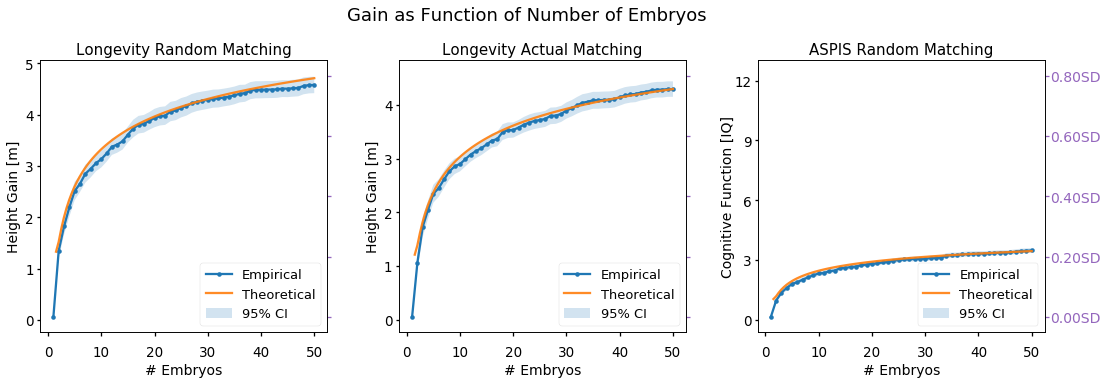

In [728]:
from matplotlib.ticker import FuncFormatter
def fix_iq_units(tick_label, tick_pos):
    return "{:.0f}".format(float(tick_label) / 4 * 15)
ax_iq.yaxis.set_major_formatter(FuncFormatter(fix_iq_units))
ax_iq.yaxis.set_label_coords(-0.08, 0.5)
fig.subplots_adjust(wspace=0.25)
fig

In [729]:
plot.save_fig(fig, "gain-by-nsibs_horizontal_sdticks_alpha-09_ticklines_rightmost-only" + 
                    ("_thick" if PLOT_THICKENS else "") + 
                    ("_approx" if APPROX_MAX else "") + 
                    ("_dillute" if DILLUTE_TICKS else "") + 
                    ("_SDticks" if UNIT_TICKS else "") + 
                    ("_SDscaled" if SD_SCALED else ""),
              SAVE_FIG_DIR)